# Supplement Section 1: Models and parameter fitting

## Setup

In [2]:
using CSV,DataFrames,Distributions,StatsBase,PythonPlot,Random,Tables,DifferentialEquations,Setfield
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))
# seed 
Random.seed!(123);

## Models: OU vs. DN

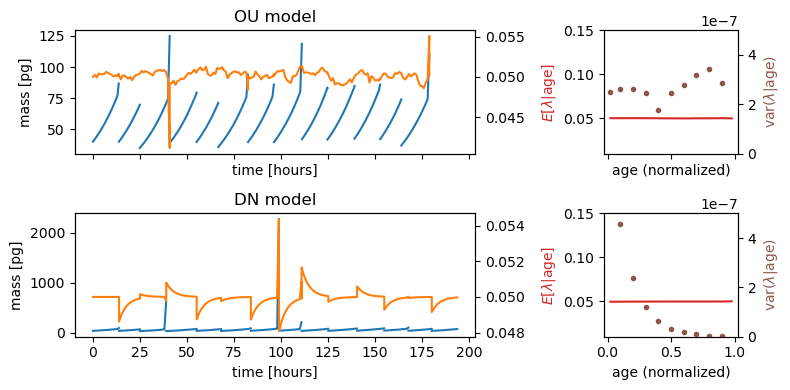

In [3]:

#  setup figure 
fig, axs = subplots(2, 2,gridspec_kw=Dict("width_ratios"=> [3, 1], "height_ratios"=> [1, 1]), figsize=(8, 4),sharex="col")

# ##############################################################################
# OU MODEL 
# ##############################################################################


# build model and run 
θ = GrowthTraceTools.θOU
θ = @set θ.D = GrowthTraceTools.σGR.^2 /2
prob,callback,names = GrowthTraceTools.build_model_OU(θ,GrowthTraceTools.initOU,collect(0:0.1:6000))
sol = solve(prob,callback = callback);
d_OU = GrowthTraceTools.solver_output_to_dataframe(sol,names);

#d = sims[sims.lineage_original .==22,:]
d = d_OU[d_OU.position .< 20,:]
da = combine(groupby(d,:age_rounded),:λ => var => :var_gr,:λ => mean => :mean_gr,:age_normed => mean => :age)


ax = axs[0,0]
ax.set_title("OU model")
ax.set_ylabel("mass [pg]")
ax.set_xlabel("time [hours]")
#d1 = d[d.replicate .==1,:]
d1 = d
[ax.plot(d1[d1.position .==p,:].time,d1[d1.position .==p,:].M,"C0") for p in unique(d1.position)]
ax2 = ax.twinx()
ax2.plot(d1.time,d1.λ,"C1")

# Create the second subplot
ax = axs[0,1]
ax.plot(da.age,da.mean_gr,"C3-")
ax.set_ylim([0.01,2*0.075])
ax.set_xlabel("age (normalized)")
ax.set_ylabel(L"$E[\lambda|{\rm age}]$",color="C3")

ax2 = ax.twinx()
ax2.plot(da.age,da.var_gr,"C5.")
ax2.set_ylabel(L"${\rm var}(\lambda|{\rm age})$",color="C5")

ax2.set_ylim([0,5e-7])

# ##############################################################################
#  MODEL 
# ##############################################################################

# -----------------------------------------------------------

θ = GrowthTraceTools.θOU
θ = @set θ.σDN = 0.0
θ = @set θ.D = 0.0
θ = @set θ.σDN = GrowthTraceTools.σGR .* 13. /θ.τ
prob,callback,names = GrowthTraceTools.build_model_OU(θ,GrowthTraceTools.initOU,collect(0:0.1:1000))
sol = solve(prob,callback = callback);
d_DN = GrowthTraceTools.solver_output_to_dataframe(sol,names);

d = d_DN[d_DN.position .< 20,:]
da = combine(groupby(d,:age_rounded),:λ => var => :var_gr,:λ => mean => :mean_gr,:age_normed => mean => :age)

ax = axs[1,0]
ax.set_ylabel("mass [pg]")
ax.set_xlabel("time [hours]")
ax.set_title("DN model")
#d1 = d[d.replicate .==1,:]
d1 = d
[ax.plot(d1[d1.position .==p,:].time,d1[d1.position .==p,:].M,"C0") for p in unique(d1.position)]
ax2 = ax.twinx()
ax2.plot(d1.time,d1.λ,"C1")

# Create the second subplot
ax = axs[1,1]
ax.plot(da.age,da.mean_gr,"C3")
ax.set_ylim([0.01,2*0.075])
ax.set_xlabel("age (normalized)")
ax.set_ylabel(L"$E[\lambda|{\rm age}]$",color="C3")

ax2 = ax.twinx()
ax2.plot(da.age,da.var_gr,"C5.")
ax2.set_ylabel(L"${\rm var}(\lambda|{\rm age})$",color="C5")

ax2.set_ylim([0,5e-7])


tight_layout()
#savefig("./../figures/supp_models1.pdf")
fig

### Test formulas for summed variance

In [4]:
θ = GrowthTraceTools.θOU
θ = @set θ.τ = 5.0
θ_OU = @set θ.D =0.00019/θ.τ

prob,callback,names = GrowthTraceTools.build_model_OU(θ_OU,GrowthTraceTools.initOU,collect(0:0.1:500))
sol = solve(prob,callback = callback);
d_OU = GrowthTraceTools.solver_output_to_dataframe(sol,names);

θ = GrowthTraceTools.θOU
θ = @set θ.D = 0.0
θ_DN = @set θ.σDN = sqrt(0.00019) .* 10 /θ.τ
prob,callback,names = GrowthTraceTools.build_model_OU(θ_DN,GrowthTraceTools.initOU,collect(0:0.1:1000))
sol = solve(prob,callback = callback);
d_DN = GrowthTraceTools.solver_output_to_dataframe(sol,names);

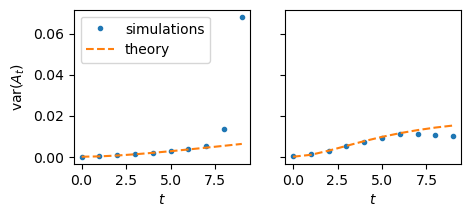

In [5]:
d_OU[:,:y] = vcat([d.lnM_sum .- d.lnM_sum[1]  for d in groupby(d_OU,[:position])]...);
d_OU[:,:ager] =  [round(x) for x in d_OU.age];
d_OU_v = combine(groupby(d_OU,:ager),:y => var => :yvar);

d_DN[:,:y] = vcat([d.lnM_sum .- d.lnM_sum[1]  for d in groupby(d_DN,[:position])]...);
d_DN[:,:ager] =  [round(x) for x in d_DN.age];
d_DN_v = combine(groupby(d_DN,:ager),:y => var => :yvar);


fig, axs= subplots(figsize=(5,2),ncols=2,sharey=true)
max_age = 10


a,v = d_OU_v[d_OU_v.ager .< max_age,:].ager,d_OU_v[d_OU_v.ager .< max_age,:].yvar
axs[0].plot(a,v,".",label="simulations")
axs[0].plot(a,GrowthTraceTools.Avar_theory_OU(a,θ_OU.D,1/θ_OU.τ),"--",label="theory")
axs[0].set_ylabel(L"${\rm var}(A_t)$")
axs[0].set_xlabel(L"$t$")
axs[0].legend()

a,v = d_DN_v[d_DN_v.ager .< max_age,:].ager,d_DN_v[d_DN_v.ager .< max_age,:].yvar
axs[1].plot(a,v,".")
axs[1].plot(a,GrowthTraceTools.Avar_theory_DN(a,θ_DN.σDN .^2,1/θ_DN.τ),"--")
axs[1].set_xlabel(L"$t$")

savefig("./../figures/supp-At_sims-vs-theory.pdf",bbox_inches="tight")
fig

## Fitting procedure and parameters

### Get data

In [6]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);

data_gp[:,:age] = vcat([d.time .- d.time[1] for d in groupby(data_gp,[:lineage,:position])]...);
data_gp[:,:y] = vcat([d.matern32_flucs .- d.matern32_flucs[1] 
for d in groupby(data_gp,[:lineage,:position])]...);
data_gp[:,:yx] = vcat([d.matern32_flucs_x .- d.matern32_flucs_x[1] 
for d in groupby(data_gp,[:lineage,:position])]...);
data_gp[:,:ager]  = round.(data_gp[:,:age]);


### Plots of fitted parameters

In [7]:
d_fits = CSV.read("./../output/fitted_params.csv",DataFrame)
d_fits[:,:t_OU] = 1 ./d_fits[:,:γ_OU];
d_fits[:,:t_DN] = 1 ./d_fits[:,:γ_DN];

In [8]:
fig,axs = subplots(figsize=(6,4),ncols=2,nrows = 2,sharey="row",sharex=true)

ax = axs[0,0]
ax.plot(lineages, 1.0 ./ d_fits.γ_OU,".")
m, v= mean(1.0 ./ d_fits.γ_OU) .* ones(length(lineages)), std(1.0 ./ d_fits.γ_OU) ./ sqrt(10)
ax.plot(lineages, m,"-")
ax.fill_between(lineages,m .- v,m .+ v,color="C1",alpha=0.4)
ax.set_ylim([0,15])

ax.set_ylabel(L"$1/\hat{\gamma}$")
ax.set_title("OU Model")

ax = axs[0,1]
ax.set_title("DN Model")
ax.plot(lineages , 1.0 ./ d_fits.γ_DN,".")
m, v= mean(1.0 ./ d_fits.γ_DN) .* ones(length(lineages)), std(1.0 ./ d_fits.γ_DN) ./ sqrt(10)
ax.plot(lineages, m,"-")
ax.fill_between(lineages,m .- v,m .+ v,color="C1",alpha=0.4)


ax = axs[1,0]
ax.plot(lineages, d_fits.D ./ d_fits.γ_OU,".")
m, v= mean(d_fits.D ./ d_fits.γ_OU) .* ones(length(lineages)), std(d_fits.D ./ d_fits.γ_OU) ./ sqrt(10)
ax.plot(lineages, m,"-")
ax.fill_between(lineages,m .- v,m .+ v,color="C1",alpha=0.4)

ax.set_ylabel(L"${\rm var}$")
ax.set_xlabel("lineage")

ax = axs[1,1]
ax.plot(lineages , d_fits.σ2,".")
m, v= mean(d_fits.σ2) .* ones(length(lineages)), std(d_fits.σ2) ./ sqrt(10)
ax.plot(lineages, m,"-")
ax.fill_between(lineages,m .- v,m .+ v,color="C1",alpha=0.4)

ax.set_xlabel("lineage")
fig

ArgumentError: ArgumentError: column name "σ2" not found in the data frame; existing most similar names are: "σM", "D", "v", "Δ" and "λ0"

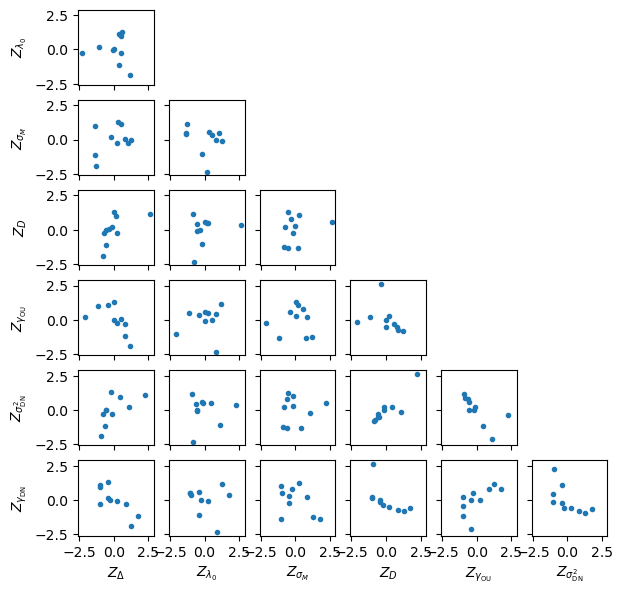

In [9]:
cols =["Δ","λ0","σM","D","γ_OU","σ2","γ_DN"]
labels =[L"$Z_{\Delta}$",L"$Z_{\lambda_0}$",L"$Z_{\sigma_M}$",L"$Z_{D}$",L"$Z_{\gamma_{\rm OU}}$",L"$Z_{\sigma_{\rm DN}^2}$",L"$Z_{\gamma_{\rm DN}}$"]

zscore = x ->  (x .- mean(x)) ./ std(x)
fig, axs= subplots(figsize=(8,8),ncols = length(cols),nrows=length(cols),sharex=true,sharey=true)
for i in eachindex(cols)
    axs[length(cols)-1,i-1].set_xlabel(labels[i])
    axs[i-1,0].set_ylabel(labels[i])
    for j in eachindex(cols)[1:i-1]
        ax = axs[i-1,j-1]
        ax.plot(zscore(d_fits[:,cols[i]]),zscore(d_fits[:,cols[j]]),".")
    end
    for j in eachindex(cols)[i:length(cols)]
        ax = axs[i-1,j-1]
        ax.spines["top"].set_visible(false)
        ax.spines["right"].set_visible(false)
        ax.spines["bottom"].set_visible(false)
        ax.spines["left"].set_visible(false)
        fig.delaxes(ax)
    end
end

savefig("./../figures/supp_fits-corrs.pdf")
fig

### Comparison of fitted predictions to data

In [8]:

# get sims
sims = CSV.read("./../output/sims_OUfit.csv",DataFrame);
sims_cells = combine(groupby(sims,[:lineage_original,:replicate,:position]),
    :λ=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length);
sims_cells[:,:lineage] = sims_cells.lineage_original



# get sim after gp
sims_gp = CSV.read("./../output/gp/sims/preds.csv",DataFrame);
sims_cells_gp = combine(groupby(sims_gp,[:lineage,:position]),
    :matern32notrend_flucs_x=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt);

sims_gp[:,:age] = vcat([d.time .- d.time[1] for d in groupby(sims_gp,[:lineage,:position])]...);
sims_gp[:,:ager] =  [round(x) for x in sims_gp.age];
sims_gp[:,:y] = vcat([d.matern32notrend_flucs .- d.matern32notrend_flucs[1] 
for d in groupby(sims_gp,[:lineage,:position])]...);
sims_gp[:,:yx] = vcat([d.matern32notrend_flucs_x .- d.matern32notrend_flucs_x[1] 
for d in groupby(sims_gp,[:lineage,:position])]...);

unique(sims_gp.lineage)

19-element Vector{Float64}:
   1.0
   2.0
  21.0
  22.0
  41.0
  42.0
  61.0
  62.0
  81.0
  82.0
 101.0
 102.0
 121.0
 122.0
 141.0
 142.0
 161.0
 162.0
 181.0

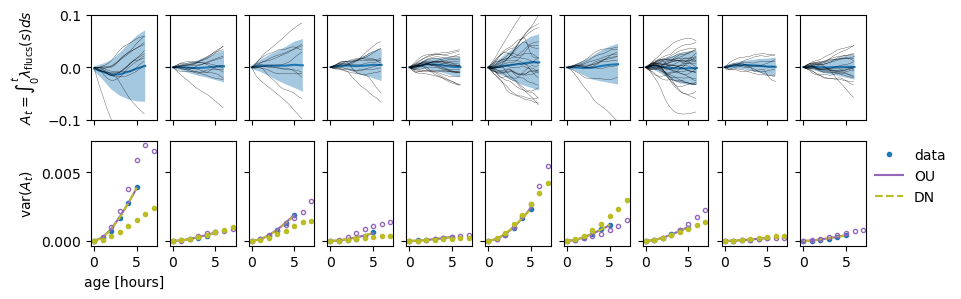

In [9]:

fig, axs= subplots(figsize=(10,3),ncols=length(lineages),nrows=2,sharey="row",sharex=true)




for k in eachindex(lineages) 


    d = data_gp[data_gp.lineage.== lineages[k],:]
    d = d[d.age .< 6,:]
    positions  = unique(d.position)
    ax = axs[0,k-1]

 
    dv = combine(groupby(d,:ager),:y=>mean => :my,:y => std => :vy)
    ax.fill_between(dv.ager,dv.my .- dv.vy,dv.my .+ dv.vy ,alpha=0.4)
    ax.plot(dv.ager,dv.my,"C0-")
    ax.set_ylim([-0.1,0.1])


    for p in groupby(d,:position)
        
        ax.plot(p.age,p.y,"k-",lw=0.2)
    end
end


for k in eachindex(lineages) 


    d = data_gp[data_gp.lineage.== lineages[k],:]
    positions  = unique(d.position)
    df = combine(groupby(d,:ager),:y => var => :Avar)
    ax = axs[1,k-1]
    inds = df.ager .< 6
    ax.plot(df.ager[inds],df.Avar[inds],".",label="data")
    D = d_fits[d_fits.lineage .== lineages[k],:D][1]
    γOU = d_fits[d_fits.lineage .== lineages[k],:γ_OU][1]
    γDN = d_fits[d_fits.lineage .== lineages[k],:γ_DN][1]
    σ2DN = d_fits[d_fits.lineage .== lineages[k],:σ2][1]
    ax.plot(df.ager[inds],GrowthTraceTools.Avar_theory_OU(df.ager[inds],D,γOU),"C4-",label="OU")
    ax.plot(df.ager[inds],GrowthTraceTools.Avar_theory_DN(df.ager[inds],σ2DN,γDN),"C8--",label="DN")
    

    dr = sims[(sims.lineage_original .== lineages[k]),:] 
    dr = dr[(dr.ϕ .== 1.0),:] 
    dr = dr[(dr.replicate .== 1),:] 
    dr[:,:ager] = round.(dr.age)
    d = sims_gp[sims_gp.lineage.== dr.lineage[1],:]
    positions  = unique(d.position)
    df = combine(groupby(d,:ager),:y => var => :Avar)
    inds = df.ager .< 8
    ax.plot(df.ager[inds],df.Avar[inds],"C4.",fillstyle="none")



    dr = sims[(sims.lineage_original .== lineages[k]),:] 
    dr = dr[(dr.ϕ .== 0.0),:] 
    dr = dr[(dr.replicate .== 1),:] 
    dr[:,:ager] = round.(dr.age)
    d = sims_gp[sims_gp.lineage.== dr.lineage[1],:]
    positions  = unique(d.position)
    df = combine(groupby(d,:ager),:y => var => :Avar)
    inds = df.ager .< 8
    ax.plot(df.ager[inds],df.Avar[inds],"C8.")
 
end

axs[0,0].set_ylabel(L"$A_t = \int_0^t\lambda_{\rm flucs}(s)ds$")

axs[1,0].set_ylabel(L"${\rm var}(A_t)$")
axs[1,0].set_xlabel("age [hours]")
axs[1,length(lineages)-1].legend(frameon=false,bbox_to_anchor=(2.4, 1.05))
savefig("./../figures/supp_At.pdf",bbox_inches="tight")

fig